In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet50_newdataset_trained/tensorflow2/default/1/resnet50_her2_classifier_full2.pth
/kaggle/input/resnet50_newdataset_trained/tensorflow2/default/1/best_model.pth
/kaggle/input/finalized-dataset-bc/test/class_3+/her2-3+-score_train_4246.png
/kaggle/input/finalized-dataset-bc/test/class_3+/her2-3+-score_train_1678.png
/kaggle/input/finalized-dataset-bc/test/class_3+/her2-3+-score_train_1225.png
/kaggle/input/finalized-dataset-bc/test/class_3+/her2-3+-score_train_1610.png
/kaggle/input/finalized-dataset-bc/test/class_3+/her2-3+-score_train_699.png
/kaggle/input/finalized-dataset-bc/test/class_3+/her2-3+-score_train_1236.png
/kaggle/input/finalized-dataset-bc/test/class_3+/her2-3+-score_train_2545.png
/kaggle/input/finalized-dataset-bc/test/class_3+/her2-3+-score_test_387.png
/kaggle/input/finalized-dataset-bc/test/class_3+/her2-3+-score_test_353.png
/kaggle/input/finalized-dataset-bc/test/class_3+/her2-3+-score_test_42.png
/kaggle/input/finalized-dataset-bc/test/class_3+/h

In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.6 MB/s eta 0:00:00:00:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=2b1a36793a3dd92e54c351e40e9aea9c6127add349360056fa62af9e48778864
  Stored in directory: /root/.cache/pip/wheels/3d/b6/be/e13cccebb2aa8855f678b02ad449e803de1dfbe75853c34b3e
Successfully built grad-cam


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

In [4]:
# Set random seed for reproducibility
import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [5]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# Define data directories
train_dir = "/kaggle/input/finalized-dataset-bc/train" 
test_dir = "/kaggle/input/finalized-dataset-bc/test"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Define class names
class_names = train_dataset.classes

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 8797
Test set size: 2200


In [7]:
# Load ResNet50 pre-trained model
model = models.resnet50(pretrained=True)

# Unfreeze all layers – full fine-tuning
for param in model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
num_classes = len(class_names)
dropout_rate = 0.3
model.fc = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(model.fc.in_features, num_classes)
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 224MB/s]


In [8]:
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR

# Define the scheduler
num_epochs = 100
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

# Early stopping variables
best_val_loss = float('inf')
patience = 5
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update running loss and accuracy
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    # Update the learning rate
    scheduler.step()

    # Log training metrics for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_predictions
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, LR: {current_lr:.6f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels).item()
            val_total += labels.size(0)

    # Log validation metrics for the epoch
    val_loss /= len(test_loader)
    val_acc = val_correct / val_total
    print(f"Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model

            
# Save the model with weights and architecture
torch.save(model, "resnet50_her2_classifier_full2.pth")
print("Model and architecture saved as 'resnet50_her2_classifier_full2.pth'")

Epoch 1/100 - Train Loss: 0.5301, Train Acc: 0.7914, LR: 0.001000
Epoch 1/100 - Val Loss: 0.3559, Val Acc: 0.8509
Epoch 2/100 - Train Loss: 0.3938, Train Acc: 0.8369, LR: 0.000999
Epoch 2/100 - Val Loss: 0.2810, Val Acc: 0.8850
Epoch 3/100 - Train Loss: 0.3805, Train Acc: 0.8397, LR: 0.000998
Epoch 3/100 - Val Loss: 0.2720, Val Acc: 0.8895
Epoch 4/100 - Train Loss: 0.3759, Train Acc: 0.8431, LR: 0.000996
Epoch 4/100 - Val Loss: 0.2824, Val Acc: 0.8814
Epoch 5/100 - Train Loss: 0.3638, Train Acc: 0.8507, LR: 0.000994
Epoch 5/100 - Val Loss: 0.2562, Val Acc: 0.8891
Epoch 6/100 - Train Loss: 0.3627, Train Acc: 0.8494, LR: 0.000991
Epoch 6/100 - Val Loss: 0.2645, Val Acc: 0.8900
Epoch 7/100 - Train Loss: 0.3460, Train Acc: 0.8592, LR: 0.000988
Epoch 7/100 - Val Loss: 0.2481, Val Acc: 0.8959
Epoch 8/100 - Train Loss: 0.3573, Train Acc: 0.8502, LR: 0.000984
Epoch 8/100 - Val Loss: 0.2419, Val Acc: 0.8950
Epoch 9/100 - Train Loss: 0.3707, Train Acc: 0.8478, LR: 0.000980
Epoch 9/100 - Val Loss

In [7]:
# Load the trained model
model_path = '/kaggle/input/resnet50model/tensorflow2/default/1/resnet50_her2_classifier_full2.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_path, map_location=device)
print("Loaded model from 'resnet50_her2_classifier_full.pth'")
model = model.to(device)
model.eval()

# Initialize placeholders for predictions
all_preds, all_labels, all_probs = [], [], []
5
# Model evaluation on test set
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert predictions to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

<ipython-input-7-0f46cbfe7ba6>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=device)


Loaded model from 'resnet50_her2_classifier_full.pth'


Classification Report:
              precision    recall  f1-score   support

     class_0       0.91      0.91      0.91       758
    class_1+       0.83      0.82      0.82       538
    class_2+       0.83      0.86      0.85       226
    class_3+       1.00      0.99      0.99       678

    accuracy                           0.91      2200
   macro avg       0.89      0.90      0.89      2200
weighted avg       0.91      0.91      0.91      2200



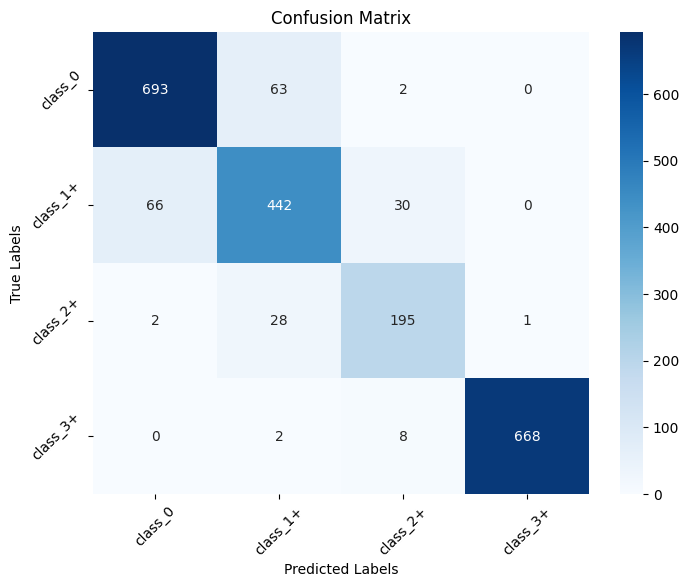

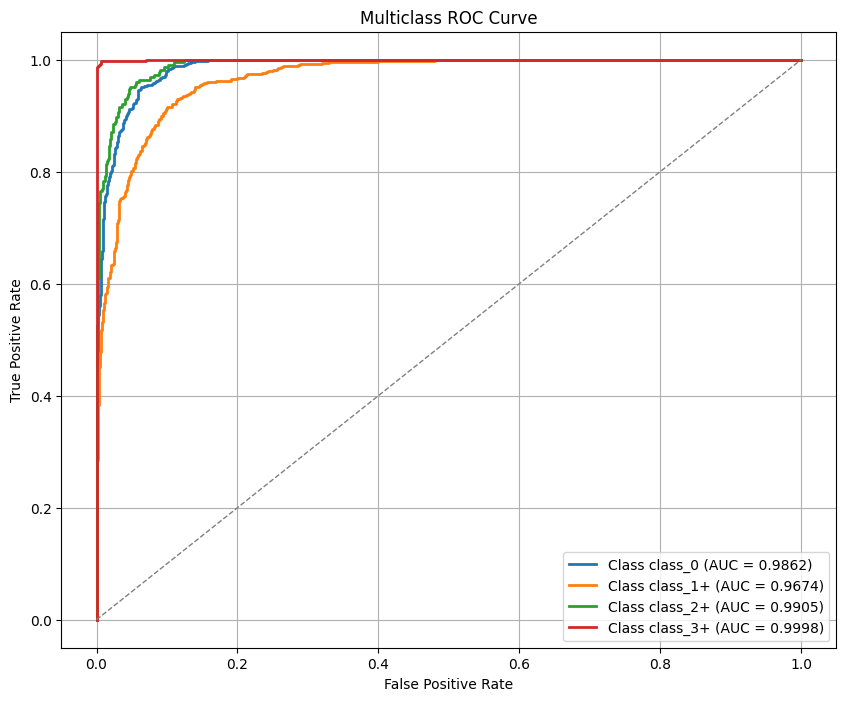

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np

# Ensure num_classes is defined
num_classes = len(test_dataset.classes)

# Compute Confusion Matrix
predicted_labels = np.argmax(all_probs, axis=1)
conf_matrix = confusion_matrix(all_labels, predicted_labels)

# Display Classification Report
class_report = classification_report(all_labels, predicted_labels, target_names=test_dataset.classes)
print("Classification Report:")
print(class_report)

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.yticks(rotation=45)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# AUC-ROC Plot
if num_classes == 2:
    # Binary Classification
    fpr, tpr, _ = roc_curve(all_labels, all_probs[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

elif num_classes > 2:
    # Multiclass Classification - One-hot encode labels
    all_labels_one_hot = label_binarize(all_labels, classes=range(num_classes))
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_one_hot[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {test_dataset.classes[i]} (AUC = {roc_auc[i]:.4f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

100%|██████████| 128/128 [00:04<00:00, 31.49it/s]


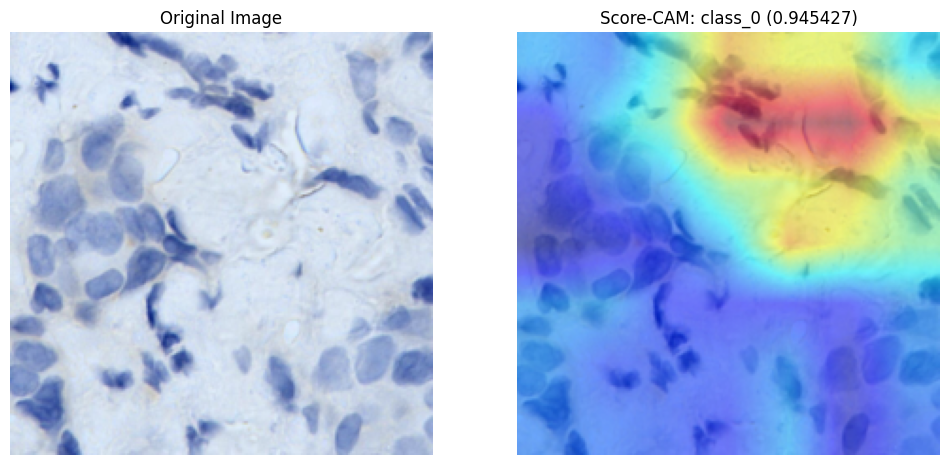

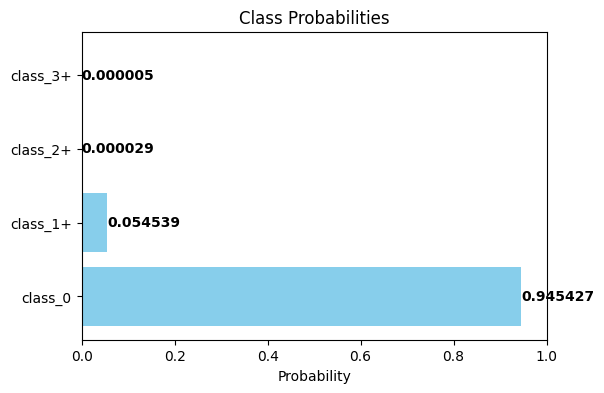

Evaluation for Image: True Label: class_0 | Predicted: class_0
Prediction Confidence: 0.945427
Accuracy: 1
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [9]:
# Score-CAM Visualization with Evaluation
def visualize_scorecam_with_eval(image, label, model, device, target_layer, class_names):
    cam = ScoreCAM(model=model, target_layers=[target_layer])
    
    # Convert image to NumPy array and ensure it's in range [0,1]
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize to [0,1]
    
    # Prepare input for ScoreCAM
    input_tensor = preprocess_image(image_np, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    target = [ClassifierOutputTarget(label)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0, :]
    
    # Overlay CAM on original image
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True, colormap=cv2.COLORMAP_JET)
    
    # Model Prediction
    with torch.no_grad():
        image_batch = image.unsqueeze(0).to(device)
        outputs = model(image_batch)
        probs = F.softmax(outputs, dim=1)
        all_class_probs = probs[0].cpu().numpy()
        pred_idx = probs.argmax(dim=1).item()
        pred_class = class_names[pred_idx]
        pred_prob = all_class_probs[pred_idx]
    
    true_label = class_names[label]
    true_idx = class_names.index(true_label)
    pred_idx = class_names.index(pred_class)
    
    # Evaluation Metrics
    accuracy = 1 if pred_class == true_label else 0
    precision = precision_score([true_idx], [pred_idx], average='micro', labels=range(len(class_names)))
    recall = recall_score([true_idx], [pred_idx], average='micro', labels=range(len(class_names)))
    f1 = f1_score([true_idx], [pred_idx], average='micro', labels=range(len(class_names)))
    
    # Display Results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(cam_image)
    plt.title(f"Score-CAM: {pred_class} ({pred_prob:.6f})")
    plt.axis("off")
    
    plt.figure(figsize=(6, 4))
    plt.barh(class_names, all_class_probs, color="skyblue")
    plt.title("Class Probabilities")
    plt.xlabel("Probability")
    plt.xlim(0, 1)  # Ensures probabilities are scaled correctly
    for i, prob in enumerate(all_class_probs):
        plt.text(prob, i, f'{prob:.6f}', va='center', ha='left', fontweight='bold')
    plt.show()
    
    # Print Evaluation
    print(f"Evaluation for Image: True Label: {true_label} | Predicted: {pred_class}")
    print(f"Prediction Confidence: {pred_prob:.6f}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Run visualization
images, labels = next(iter(test_loader))
target_image, target_label = images[27].to(device), labels[27].item()
visualize_scorecam_with_eval(target_image, target_label, model, device, model.layer4[-1], class_names)


100%|██████████| 128/128 [00:03<00:00, 33.35it/s]


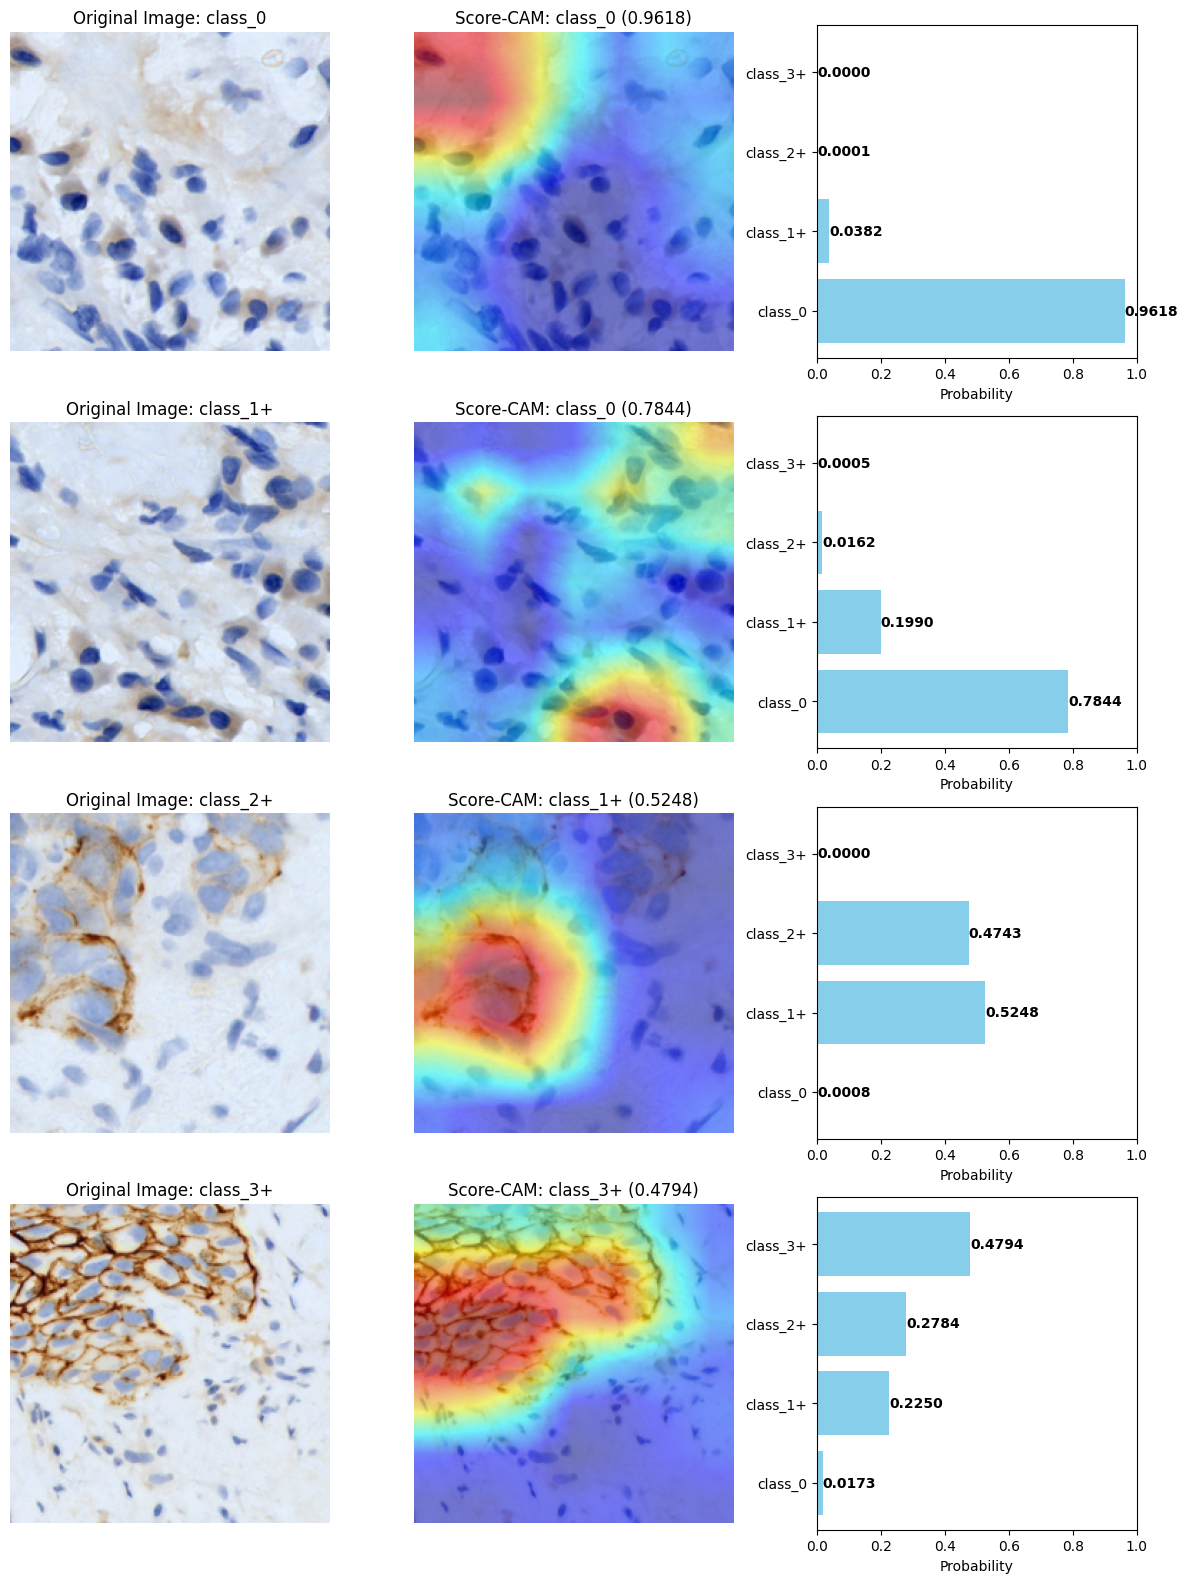

Explainability Statistics:
Mean Activation Intensity: 0.3326
Mean Confidence Spread: 0.4401
Mean Explainability Score: 0.6394


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F
import cv2
from pytorch_grad_cam import ScoreCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from scipy.stats import entropy

# Ensure num_classes is defined
num_classes = len(test_dataset.classes)

def visualize_scorecam_with_stats(dataloader, model, device, target_layer, class_names):
    cam = ScoreCAM(model=model, target_layers=[target_layer])
    selected_samples = {}
    
    # Iterate over multiple batches if needed
    for images, labels in dataloader:
        for image, label in zip(images, labels):
            label_int = label.item()
            if label_int not in selected_samples:
                selected_samples[label_int] = image
            if len(selected_samples) == num_classes:
                break
        if len(selected_samples) == num_classes:
            break
    
    if len(selected_samples) < num_classes:
        print("Warning: Could not find examples for all classes in the test set!")
    
    plt.figure(figsize=(12, num_classes * 4))
    
    explainability_scores = []
    mean_activation_intensities = []
    confidence_spreads = []
    
    for i, (true_label, image) in enumerate(selected_samples.items()):
        image_np = image.permute(1, 2, 0).cpu().numpy()
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
        input_tensor = preprocess_image(image_np, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        target = [ClassifierOutputTarget(true_label)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0, :]
        cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True, colormap=cv2.COLORMAP_JET)
        
        with torch.no_grad():
            image_batch = image.unsqueeze(0).to(device)
            outputs = model(image_batch)
            probs = F.softmax(outputs, dim=1)
            all_class_probs = probs[0].cpu().numpy()
            pred_idx = probs.argmax(dim=1).item()
            pred_class = class_names[pred_idx]
            pred_prob = all_class_probs[pred_idx]
        
        # Compute statistics
        mean_activation = np.mean(grayscale_cam)
        confidence_spread = pred_prob - sorted(all_class_probs)[-2]
        explainability_score = entropy(all_class_probs)
        
        mean_activation_intensities.append(mean_activation)
        confidence_spreads.append(confidence_spread)
        explainability_scores.append(explainability_score)
        
        # Visualization
        plt.subplot(num_classes, 3, 3 * i + 1)
        plt.imshow(image_np)
        plt.title(f"Original Image: {class_names[true_label]}")
        plt.axis("off")
        
        plt.subplot(num_classes, 3, 3 * i + 2)
        plt.imshow(cam_image)
        plt.title(f"Score-CAM: {pred_class} ({pred_prob:.4f})")
        plt.axis("off")
        
        plt.subplot(num_classes, 3, 3 * i + 3)
        plt.barh(class_names, all_class_probs, color="skyblue")
        plt.xlabel("Probability")
        plt.xlim(0, 1)
        for j, prob in enumerate(all_class_probs):
            plt.text(prob, j, f'{prob:.4f}', va='center', ha='left', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics summary
    print("Explainability Statistics:")
    print(f"Mean Activation Intensity: {np.mean(mean_activation_intensities):.4f}")
    print(f"Mean Confidence Spread: {np.mean(confidence_spreads):.4f}")
    print(f"Mean Explainability Score: {np.mean(explainability_scores):.4f}")

# Run visualization with added statistics
dataloader_iter = iter(test_loader)
visualize_scorecam_with_stats(dataloader_iter, model, device, model.layer4[-1], class_names)
